In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-26 14:06:01.741183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-26 14:06:02.925867: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-26 14:06:02.926624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-26 14:06:02.972539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 14:06:02.972653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-06-26 14:06:02.972670: I tensorflow/stream_executor/platform/def

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.visualization.plotting_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.deep_learning.neural_networks.create_conv_model import create_conv_model
from src.deep_learning.soundtype_classifier.classifier_datasets import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Choose dataset
path_to_datasets = PATH_TO_PROJECT + 'models/classifier/datasets/'
path_to_models = PATH_TO_PROJECT + 'models/classifier/networks/'
all_datasets = os.listdir(path_to_datasets)
print('Datasets:')
print('\n'.join(all_datasets))
dataset_name = all_datasets[3]

print('\nCHOSEN: ')
print(dataset_name)

Datasets:
nmr_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
hvd_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=True_highpass=3000
dam_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=True_highpass=3000
berlin_new-specs_im-augment=5_nfft=512_shape=(128, 64)_denoise=False_hpass=3000
dam_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
hvd_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
berlin_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
bsuil_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000

CHOSEN: 
berlin_new-specs_im-augment=5_nfft=512_shape=(128, 64)_denoise=False_hpass=3000


In [13]:
# Load data
(sounds_metadata_train, sounds_npy_train, melspecs_train, sounds_metadata_test,
 sounds_npy_test, melspecs_test, all_classes_str) = load_dataset(path_to_datasets, dataset_name)

In [14]:
sounds_metadata_train['cl'].value_counts()

softchirp      14470
downsweep       8295
pupcombo        7155
combo           6615
combotwo        6570
whistle         6400
scream          5950
grunt           5400
pupcheveron     5400
loudchirp       5265
upsweep         5060
pupsquawk       4725
hiccup          3315
Name: cl, dtype: int64

In [15]:
sounds_metadata_test['cl'].value_counts()

softchirp      1105
pupcombo        215
downsweep       192
pupcheveron      70
whistle          59
combo            38
pupsquawk        38
grunt            37
combotwo         26
upsweep          19
loudchirp        19
hiccup            6
Name: cl, dtype: int64

In [16]:
# Print some info about the datset
print('All classes:\n', all_classes_str)
print('\n      Training sounds:')
print(sounds_metadata_train['cl'].value_counts())
print('\n      Test sounds:')
print(sounds_metadata_test['cl'].value_counts())

All classes:
 ['combo', 'combotwo', 'downsweep', 'grunt', 'hiccup', 'loudchirp', 'pupcheveron', 'pupcombo', 'pupsquawk', 'scream', 'softchirp', 'upsweep', 'whistle']

      Training sounds:
softchirp      14470
downsweep       8295
pupcombo        7155
combo           6615
combotwo        6570
whistle         6400
scream          5950
grunt           5400
pupcheveron     5400
loudchirp       5265
upsweep         5060
pupsquawk       4725
hiccup          3315
Name: cl, dtype: int64

      Test sounds:
softchirp      1105
pupcombo        215
downsweep       192
pupcheveron      70
whistle          59
combo            38
pupsquawk        38
grunt            37
combotwo         26
upsweep          19
loudchirp        19
hiccup            6
Name: cl, dtype: int64


In [17]:
# Transform labels into numerical format, get spec shape, transform data to 4 dimensions.
y_train_str = sounds_metadata_train['cl']
y_test_str = sounds_metadata_test['cl']
y_train = y_train_str.apply(lambda x: all_classes_str.index(x))
y_test = y_test_str.apply(lambda x: all_classes_str.index(x))
if len(melspecs_train.shape) < 4:
    melspecs_train = melspecs_train.reshape((*melspecs_train.shape, 1))
if len(melspecs_test.shape) < 4:
    melspecs_test = melspecs_test.reshape((*melspecs_test.shape, 1))
img_shape = melspecs_train.shape[1:3]
print('Image shape:', img_shape)

Image shape: (128, 64)


In [18]:
model = create_conv_model(img_shape, all_classes_str)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 64, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 16, 64)        3

2022-06-26 14:07:25.538244: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 14:07:25.538999: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-26 14:07:25.539190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 14:07:25.539274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-06-26 14:

In [19]:
epochs = 20
model.fit(melspecs_train, y_train, epochs=epochs, batch_size=256, validation_data=(melspecs_test, y_test))
model.save(path_to_models + dataset_name)

2022-06-26 14:07:34.509405: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2772828160 exceeds 10% of free system memory.
2022-06-26 14:07:35.677907: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-26 14:07:35.699944: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


Epoch 1/128


2022-06-26 14:07:36.163623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-26 14:07:36.917183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-26 14:07:36.940520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-06-26 14:07:40.252970: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:40.254892: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.0/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to custo

2022-06-26 14:07:43.358492: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:43.478007: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:43.595529: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:43.715983: W tensorflow/stream_executor/gpu/

2022-06-26 14:07:46.673643: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:46.789583: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:46.916495: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:47.032773: W tensorflow/stream_executor/gpu/

2022-06-26 14:07:50.037944: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:50.154768: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:50.274327: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:50.391479: W tensorflow/stream_executor/gpu/

2022-06-26 14:07:53.341233: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:53.459403: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:53.462688: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-26 14:07:53.597950: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get t

2022-06-26 14:07:56.414657: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:56.530805: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:56.647867: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:56.766326: W tensorflow/stream_executor/gpu/

2022-06-26 14:07:59.755608: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:59.875792: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:07:59.998549: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:00.117833: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:03.095610: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:03.212671: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:03.333989: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:03.451998: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:06.535021: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:06.651927: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:06.775572: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:06.891389: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:09.930510: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:10.048812: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:10.167914: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:10.281845: W tensorflow/stream_executor/gpu/

  2/331 [..............................] - ETA: 19s - loss: 2.5582 - sparse_categorical_accuracy: 0.1172    

2022-06-26 14:08:10.634556: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:10.748821: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



330/331 [============================>.] - ETA: 0s - loss: 1.2904 - sparse_categorical_accuracy: 0.5678

2022-06-26 14:08:29.019320: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:29.157025: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:29.298194: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:29.431568: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:32.797912: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:32.919388: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:33.047733: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:33.168287: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:36.454960: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:36.576620: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:36.701473: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:36.826496: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:39.952033: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:40.075511: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:40.202450: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:40.325358: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:43.435202: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:43.559748: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:43.686300: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:43.808437: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:46.904123: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:47.025860: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:47.149876: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:47.272457: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:50.393156: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:50.516730: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:50.640628: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:50.762775: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:53.927133: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:54.048951: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:54.177579: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:54.299338: W tensorflow/stream_executor/gpu/

2022-06-26 14:08:57.531539: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:57.652913: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:57.804427: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:08:57.926834: W tensorflow/stream_executor/gpu/

2022-06-26 14:09:01.139684: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:01.261157: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



331/331 [==============================] - ETA: 0s - loss: 1.2889 - sparse_categorical_accuracy: 0.5682

2022-06-26 14:09:01.404964: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:01.528173: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:01.847000: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 59768832 exceeds 10% of free system memory.
2022-06-26 14:09:02.308408: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas 

2022-06-26 14:09:05.335293: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:05.457837: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:05.586418: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:05.710283: W tensorflow/stream_executor/gpu/

2022-06-26 14:09:08.886197: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:09.008702: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:09.136552: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:09.259085: W tensorflow/stream_executor/gpu/

2022-06-26 14:09:12.418551: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:12.542064: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:12.667081: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:12.790784: W tensorflow/stream_executor/gpu/

2022-06-26 14:09:15.912960: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:16.035949: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



331/331 [==============================] - 101s 199ms/step - loss: 1.2874 - sparse_categorical_accuracy: 0.5687 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8739
Epoch 2/128
  1/331 [..............................] - ETA: 19s - loss: 0.3300 - sparse_categorical_accuracy: 0.8828

2022-06-26 14:09:16.160617: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:09:16.283406: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



331/331 [==============================] - 18s 56ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.3832 - val_sparse_categorical_accuracy: 0.8876
Epoch 3/128
331/331 [==============================] - 18s 56ms/step - loss: 0.1608 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.4316 - val_sparse_categorical_accuracy: 0.8980
Epoch 4/128
331/331 [==============================] - 18s 56ms/step - loss: 0.1172 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.4327 - val_sparse_categorical_accuracy: 0.8882
Epoch 5/128
331/331 [==============================] - 18s 56ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.4338 - val_sparse_categorical_accuracy: 0.8980
Epoch 6/128
331/331 [==============================] - 18s 56ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.5450 - val_sparse_categorical_accuracy: 0.8898
Epoch 7/128
331/331 [==============================] - 18s 56ms/step - loss: 0.0559 - sparse_cate

KeyboardInterrupt: 

In [20]:
model.save(path_to_models + dataset_name)

2022-06-26 14:20:12.872064: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/gr1/Projects/naked-mole-rats/models/classifier/networks/berlin_new-specs_im-augment=5_nfft=512_shape=(128, 64)_denoise=False_hpass=3000/assets


In [21]:
y_train_predicted_probs = model.predict(melspecs_train)
y_train_predicted = np.argmax(y_train_predicted_probs, 1)
y_test_predicted_probs = model.predict(melspecs_test)
y_test_predicted = np.argmax(y_test_predicted_probs, 1)

2022-06-26 14:20:16.089437: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2772828160 exceeds 10% of free system memory.
2022-06-26 14:20:23.446025: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:23.633245: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:23.819395: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxa

2022-06-26 14:20:28.323987: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:28.510383: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:28.707058: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:28.890773: W tensorflow/stream_executor/gpu/

2022-06-26 14:20:33.445405: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:33.633243: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:33.820434: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:34.008857: W tensorflow/stream_executor/gpu/

2022-06-26 14:20:38.681441: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:38.868116: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:39.053724: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:39.238589: W tensorflow/stream_executor/gpu/

2022-06-26 14:20:43.889771: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:44.072816: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:44.258740: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 14:20:44.284506: W tensorflow/core/framework/cpu_a

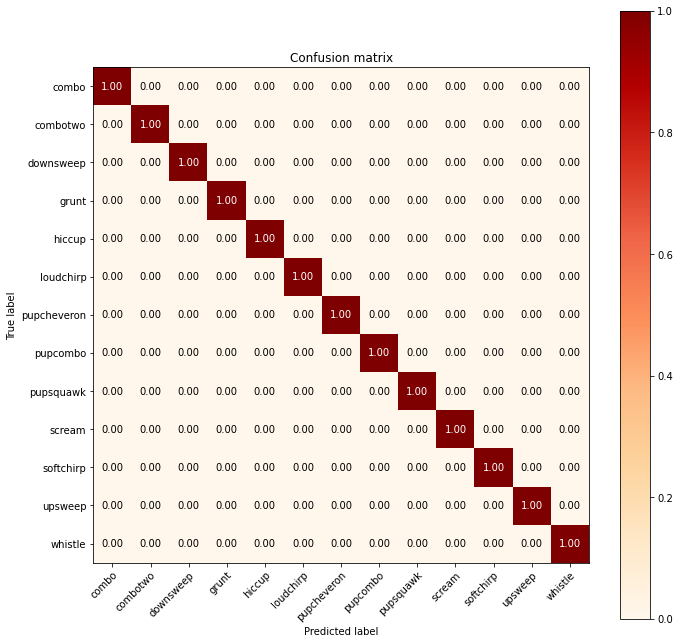

In [22]:
# Confusion matrix on the train data
cm = confusion_matrix(y_train, y_train_predicted)
fig = plot_confusion_matrix(cm, all_classes_str, 
                            figsize = (10, 10), cmap = plt.cm.OrRd, normalize = True, clim = (0, 1))
fig.savefig(path_to_models + dataset_name + '/confusion_matrix_train.png')

/home/gr1/Projects/naked-mole-rats/src/visualization/plotting_utils.py:34: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


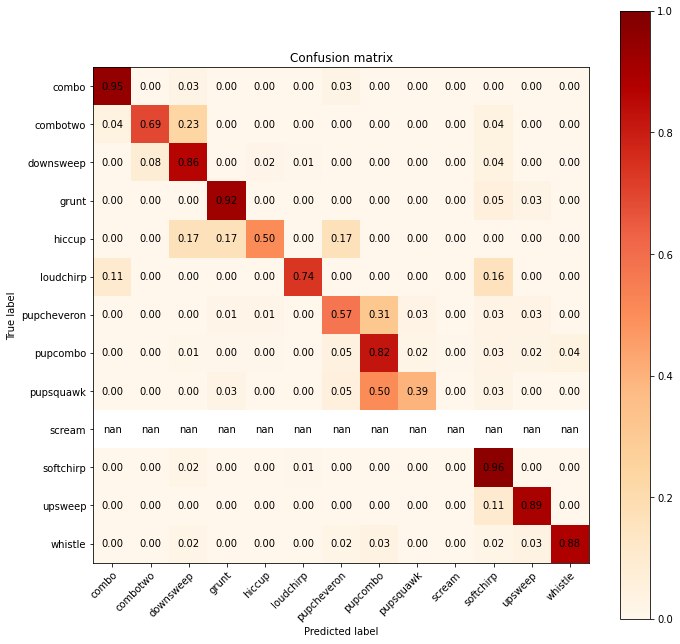

In [23]:
# Confusion matrix on the test data
cm = confusion_matrix(y_test, y_test_predicted)
fig = plot_confusion_matrix(cm, all_classes_str, 
                            figsize = (10, 10), cmap = plt.cm.OrRd, normalize = True, clim = (0, 1))
fig.savefig(path_to_models + dataset_name + '/confusion_matrix_test.png')